In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe
from glob import glob

## Load data

In [2]:
graham_bounds_lon = (-1.097336964854837, 6.678666317415254)
graham_bounds_lat = (43.606726162855736, 49.30310066033266)

In [3]:
# GCMs
## MPI-ESM1-2-LR - precipitation
files = sorted(glob("./MPI-pr/ssp370/*.nc"))
mpi_pr = xr.open_mfdataset(files, combine="by_coords")
mpi_pr = mpi_pr.sel(time=slice("1950", "2100"))
mpi_pr = mpi_pr.assign_coords(lon=((mpi_pr.lon + 180) % 360) - 180).sortby("lon")
mpi_pr = mpi_pr.sel(
    lon=slice(-5., 10),
    lat=slice(40., 55.))
mpi_pr["pr"].data = mpi_pr["pr"] * 86_400  # from kg m-2 s-1 to mm day-1

#mpi_pr = xr.open_dataset("./MPI-pr/pr_FR_MPI-ESM1-2-LR_370.nc")

## CNRM-CM - sfcWind
cnrm_wind = xr.open_dataset("./sfcWind_FR_CNRM-ESM2-1_370.nc")
cnrm_wind = cnrm_wind.sel(
    lon=slice(-5., 10),
    lat=slice(40., 55.))

# SAFRAN
safran = xr.concat(
    [xr.open_dataset("safran_1958_1988.nc"),
     xr.open_dataset("safran_1989_2025.nc")],
    dim="time"
)
safran = safran.reindex(y=safran.y.values[::-1])
safran = safran.sel(x=slice(*graham_bounds_lon), y=slice(*graham_bounds_lat))

mpi_pr = mpi_pr.convert_calendar("noleap")
cnrm_wind = cnrm_wind.convert_calendar("noleap")
safran = safran.convert_calendar("noleap")

mpi_pr.drop_attrs(), cnrm_wind.drop_attrs(), safran.drop_attrs()

/var/folders/xq/51rg1gq97lx6k2_j0sx9cwn40000gn/T/ipykernel_91891/433191970.py:4: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  mpi_pr = xr.open_mfdataset(files, combine="by_coords")
/var/folders/xq/51rg1gq97lx6k2_j0sx9cwn40000gn/T/ipykernel_91891/433191970.py:21: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  sa

(<xarray.Dataset> Size: 30MB
 Dimensions:    (time: 55115, bnds: 2, lat: 8, lon: 8)
 Coordinates:
   * time       (time) object 441kB 1950-01-01 12:00:00 ... 2100-12-31 12:00:00
   * lat        (lat) float64 64B 40.1 41.97 43.83 45.7 47.56 49.43 51.29 53.16
   * lon        (lon) float64 64B -3.75 -1.875 0.0 1.875 3.75 5.625 7.5 9.375
 Dimensions without coordinates: bnds
 Data variables:
     time_bnds  (time, bnds) datetime64[ns] 882kB dask.array<chunksize=(1, 2), meta=np.ndarray>
     lat_bnds   (time, lat, bnds) float64 7MB dask.array<chunksize=(6128, 8, 2), meta=np.ndarray>
     lon_bnds   (time, lon, bnds) float64 7MB dask.array<chunksize=(6128, 8, 2), meta=np.ndarray>
     pr         (time, lat, lon) float32 14MB dask.array<chunksize=(1, 8, 8), meta=np.ndarray>,
 <xarray.Dataset> Size: 20MB
 Dimensions:  (time: 55115, lat: 8, lon: 11)
 Coordinates:
   * time     (time) object 441kB 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
   * lat      (lat) float64 64B 41.32 42.72 44.12 45.52

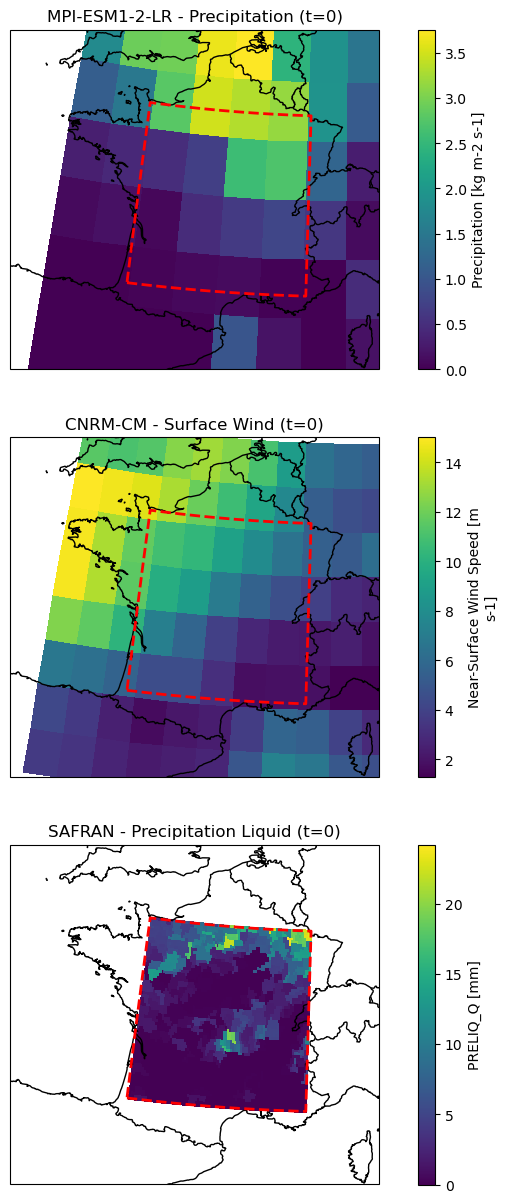

In [4]:
# Define the spatial extent (min_lon, max_lon, min_lat, max_lat)
extent = [-5.625, 9.844, 41.32, 51.13]

# Define the square borders
square_lon = [graham_bounds_lon[0], graham_bounds_lon[1], graham_bounds_lon[1], graham_bounds_lon[0], graham_bounds_lon[0]]
square_lat = [graham_bounds_lat[0], graham_bounds_lat[0], graham_bounds_lat[1], graham_bounds_lat[1], graham_bounds_lat[0]]

# Define the EuroPP projection
europp = ccrs.EuroPP()

fig, axs = plt.subplots(3, 1, figsize=(10, 15), subplot_kw={'projection': europp})

# Add the square to each plot
for ax in axs:
    ax.plot(square_lon, square_lat, transform=ccrs.PlateCarree(), color='red', linewidth=2, linestyle='--')

# Plot snapshot at t=0 for mpi_pr
mpi_pr['pr'].isel(time=0).plot(ax=axs[0], cmap='viridis', transform=ccrs.PlateCarree())
axs[0].set_title('MPI-ESM1-2-LR - Precipitation (t=0)')
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[0].set_extent(extent, crs=ccrs.PlateCarree())

# Plot snapshot at t=0 for cnrm_wind
cnrm_wind['sfcWind'].isel(time=0).plot(ax=axs[1], cmap='viridis', transform=ccrs.PlateCarree())
axs[1].set_title('CNRM-CM - Surface Wind (t=0)')
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[1].set_extent(extent, crs=ccrs.PlateCarree())

# Plot snapshot at t=0 for safran
safran['PRELIQ_Q'].isel(time=0).plot(ax=axs[2], cmap='viridis', transform=ccrs.PlateCarree())
axs[2].set_title('SAFRAN - Precipitation Liquid (t=0)')
axs[2].coastlines()
axs[2].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[2].set_extent(extent, crs=ccrs.PlateCarree())

## Regrid to target SAFRAN grid (8km)

In [5]:
import xesmf as xe

# Generate regridders from input and target grids
cnrm_to_safran = xe.Regridder(
    cnrm_wind,
    safran,
    'bilinear')
mpi_to_safran = xe.Regridder(
    mpi_pr,
    safran,
    'bilinear',
    extrap_method='nearest_s2d')

In [6]:
# Apply regridding
cnrm_wind_regridded = cnrm_to_safran(cnrm_wind)
mpi_pr_regridded = mpi_to_safran(mpi_pr)

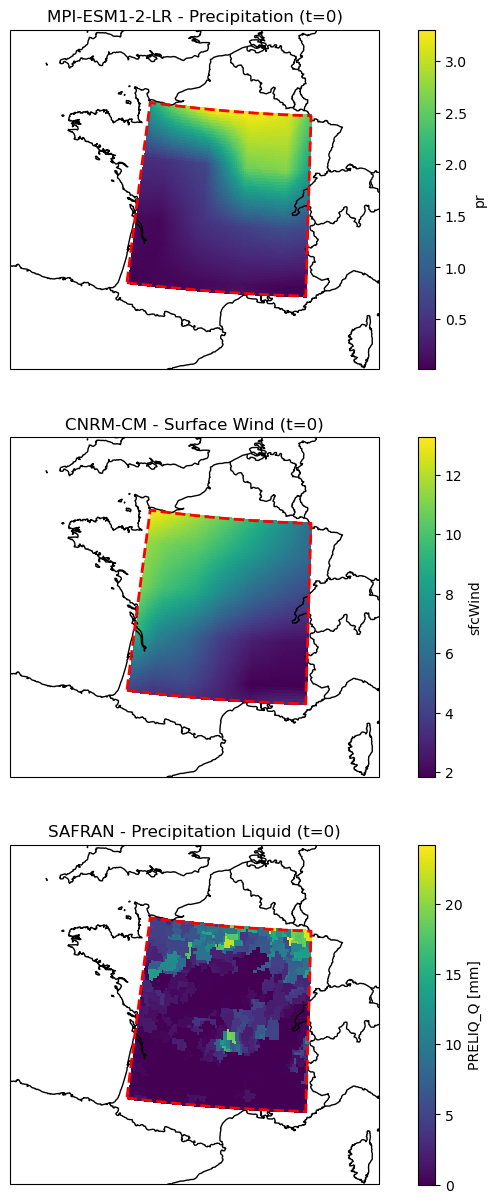

In [7]:
# Define the spatial extent (min_lon, max_lon, min_lat, max_lat)
extent = [-5.625, 9.844, 41.32, 51.13]

# Define the square borders
square_lon = [graham_bounds_lon[0], graham_bounds_lon[1], graham_bounds_lon[1], graham_bounds_lon[0], graham_bounds_lon[0]]
square_lat = [graham_bounds_lat[0], graham_bounds_lat[0], graham_bounds_lat[1], graham_bounds_lat[1], graham_bounds_lat[0]]

# Define the EuroPP projection
europp = ccrs.EuroPP()

fig, axs = plt.subplots(3, 1, figsize=(10, 15), subplot_kw={'projection': europp})

# Add the square to each plot
for ax in axs:
    ax.plot(square_lon, square_lat, transform=ccrs.PlateCarree(), color='red', linewidth=2, linestyle='--')

# Plot snapshot at t=0 for mpi_pr_regridded
mpi_pr_regridded['pr'].isel(time=0).plot(ax=axs[0], cmap='viridis', transform=ccrs.PlateCarree())
axs[0].set_title('MPI-ESM1-2-LR - Precipitation (t=0)')
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[0].set_extent(extent, crs=ccrs.PlateCarree())

# Plot snapshot at t=0 for cnrm_wind_regridded
cnrm_wind_regridded['sfcWind'].isel(time=0).plot(ax=axs[1], cmap='viridis', transform=ccrs.PlateCarree())
axs[1].set_title('CNRM-CM - Surface Wind (t=0)')
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[1].set_extent(extent, crs=ccrs.PlateCarree())

# Plot snapshot at t=0 for safran_regridded
safran['PRELIQ_Q'].isel(time=0).plot(ax=axs[2], cmap='viridis', transform=ccrs.PlateCarree())
axs[2].set_title('SAFRAN - Precipitation Liquid (t=0)')
axs[2].coastlines()
axs[2].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[2].set_extent(extent, crs=ccrs.PlateCarree())

In [8]:
print("CNRM Wind Regridded Dimensions:")
print(cnrm_wind_regridded.dims)
print(cnrm_wind_regridded.time.min(), cnrm_wind_regridded.time.max())

print("\nMPI Precipitation Regridded Dimensions:")
print(mpi_pr_regridded.dims)
print(mpi_pr_regridded.time.min(), mpi_pr_regridded.time.max())

print("\nSAFRAN Dimensions:")
print(safran.dims)
print(safran.time.min(), safran.time.max())

CNRM Wind Regridded Dimensions:
FrozenMappingWarningOnValuesAccess({'time': 55115, 'y': 64, 'x': 86})
<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(1950, 1, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object) <xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(2100, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)

MPI Precipitation Regridded Dimensions:
FrozenMappingWarningOnValuesAccess({'time': 55115, 'y': 64, 'x': 86})
<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(1950, 1, 1, 12, 0, 0, 0, has_year_zero=True),
      dtype=object) <xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(2100, 12, 31, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)

SAFRAN Dimensions:
FrozenMappingWarningOnValuesAccess({'time': 24563, 'x': 86, 'y': 64})
<xarray.DataArray 'time' ()> Size: 8B
array(cftime.DatetimeNoLeap(1958, 8, 1, 0, 0, 0, 0, has_year_zero=True),
      dtype=object) <xarray.DataArray 'time' ()> Size: 8

## Apply CDFt to regridded

In [9]:
import numpy as np
import time
import scipy.stats as st
from tqdm import tqdm


def quantile_transfer(x_train, y_train, x_test):
    n = len(x_train)
    F_xtest = st.rankdata(x_test, method="average") / n
    y_sorted = np.sort(y_train)
    mapped_to_y = np.quantile(y_sorted, F_xtest)

    x_train_sorted = np.sort(x_train)
    x_test_sorted = np.sort(x_test)
    F_xtrain_of_mapped = np.searchsorted(x_train_sorted, mapped_to_y, side="right") / n
    F_xtrain_of_mapped = np.clip(F_xtrain_of_mapped, 0, 1)
    x_test_corrected = np.quantile(x_test_sorted, F_xtrain_of_mapped)
    return x_test_corrected


def cdft_groupby(gcm_past, obs_past, gcm_fut, function):
    results = []
    for month in tqdm(range(1, 13), desc="Processing by month"):
        x_train = gcm_past.sel(time=gcm_past.time.dt.month == month)
        y_train = obs_past.sel(time=obs_past.time.dt.month == month)
        x_test = gcm_fut.sel(time=gcm_fut.time.dt.month == month)

        if x_train.time.size == 0 or y_train.time.size == 0 or x_test.time.size == 0:
            print(f"Skipping month {month}: one of the arrays is empty.")
            continue

        corrected = xr.apply_ufunc(
            function,
            x_train,
            y_train,
            x_test,
            input_core_dims=[["time"], ["time"], ["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            output_dtypes=[x_test.dtype],
            join="override"
        ).transpose("time", "x", "y")
        results.append(corrected)

    if results:
        corrected_all = xr.concat(results, dim="time").sortby("time")
        return corrected_all
    else:
        raise ValueError("No valid monthly data to correct; all months were skipped.")

In [10]:
print(f"Start CDF-t with Python")

calibration_period = ("1980", "2000")

time_now = time.time()

cdft_cnrm_wind_outputs = dict()
cdft_mpi_pr_outputs = dict()

for start_year in (2000, 2020, 2040, 2060, 2080):
    end_year = start_year + 20
    print(f"Historical: {calibration_period[0]}-{calibration_period[1]}; Application: {start_year}-{end_year}")

    gcm_past = mpi_pr_regridded["pr"].sel(time=slice(*calibration_period)).compute()
    obs_past = safran["PRELIQ_Q"].sel(time=slice(*calibration_period)).compute()
    gcm_fut = mpi_pr_regridded["pr"].sel(time=slice(str(start_year), str(end_year))).compute()

    cdft_mpi_pr = cdft_groupby(
        gcm_past=gcm_past,
        obs_past=obs_past,
        gcm_fut=gcm_fut,
        function=quantile_transfer).transpose("time", "y", "x")
    cdft_mpi_pr = cdft_mpi_pr.assign_coords(time=mpi_pr_regridded["pr"].sel(time=slice(str(start_year), str(end_year))).time)

    # store in dict
    cdft_mpi_pr_outputs[f"{start_year}-{end_year}"] = cdft_mpi_pr
    # OR save to netcdf
    # ds = xr.Dataset(
    #     data_vars={"CDFt": cdft_mpi_pr, "Interpolated-GCM": mpi_pr_regridded["pr"].sel(time=slice(str(start_year), str(end_year)))},
    # )
    #ds.to_netcdf(f"./CDFt/CDFt_MPI_pr_{start_year}-{end_year}.nc", engine="netcdf4", mode="w")
    
    # --- 

    gcm_past = cnrm_wind_regridded["sfcWind"].sel(time=slice(*calibration_period)).compute()
    obs_past = safran["FF_Q"].sel(time=slice(*calibration_period)).compute()
    gcm_fut = cnrm_wind_regridded["sfcWind"].sel(time=slice(str(start_year), str(end_year))).compute()

    cdft_cnrm_wind = cdft_groupby(
        gcm_past=gcm_past,
        obs_past=obs_past,
        gcm_fut=gcm_fut,
        function=quantile_transfer).transpose("time", "y", "x")
    cdft_cnrm_wind = cdft_cnrm_wind.assign_coords(time=cnrm_wind_regridded["sfcWind"].sel(time=slice(str(start_year), str(end_year))).time)
    
    # store in dict
    cdft_cnrm_wind_outputs[f"{start_year}-{end_year}"] = cdft_cnrm_wind
    # OR save to netcdf
    # ds = xr.Dataset(
    #     data_vars={"CDFt": cdft_cnrm_wind, "Interpolated-GCM": cnrm_wind_regridded["sfcWind"].sel(time=slice(str(start_year), str(end_year)))},
    # )
    #ds.to_netcdf(f"./CDFt/CDFt_CNRM_sfcWind_{start_year}-{end_year}.nc", engine="netcdf4", mode="w")


print(f"Duration: {time.time()-time_now} seconds")

Start CDF-t with Python
Historical: 1980-2000; Application: 2000-2020


Processing by month: 100%|██████████| 12/12 [00:24<00:00,  2.06s/it]


Historical: 1980-2000; Application: 2020-2040


Processing by month: 100%|██████████| 12/12 [00:24<00:00,  2.07s/it]


Historical: 1980-2000; Application: 2040-2060


Processing by month: 100%|██████████| 12/12 [00:24<00:00,  2.07s/it]


Historical: 1980-2000; Application: 2060-2080


KeyboardInterrupt: 

In [ ]:
# If stored to dict, can export CDFt results to .nc files
# for k, v in cdft_cnrm_wind_outputs.items():
#     print(k)
#     print(v)
#     v.to_netcdf(f"./CDFt/CDFt_CNRM_sfcWind_{k}.nc", engine="netcdf4", mode="w")

# for k, v in cdft_mpi_pr_outputs.items():
#     print(k)
#     print(v)
#     v.to_netcdf(f"./CDFt/CDFt_MPI_pr_{k}.nc", engine="netcdf4", mode="w")

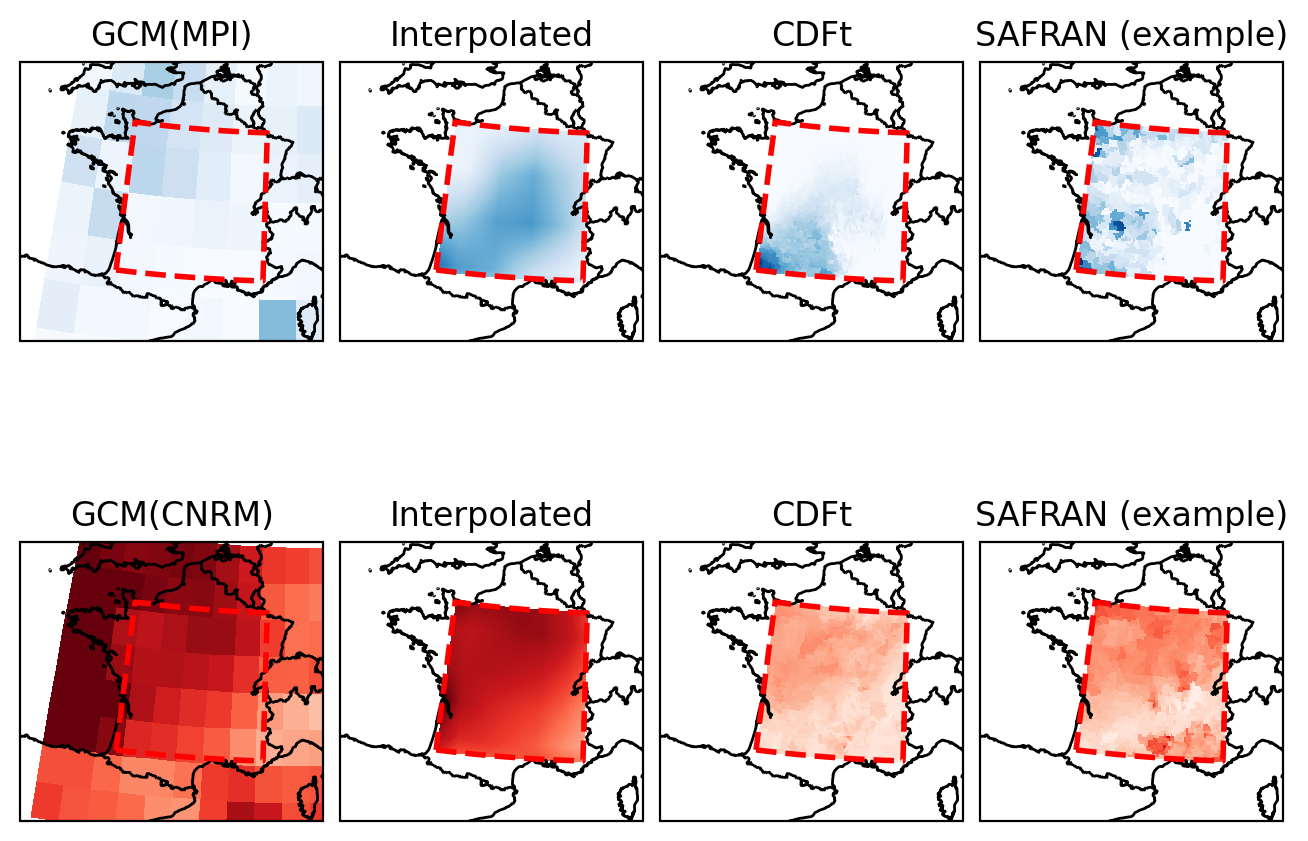

In [14]:
# --- Plot the results at different steps of the pipeline ---
t = np.random.randint(360*20)
years = ("2000", "2020")

# Define the spatial extent (min_lon, max_lon, min_lat, max_lat)
extent = [-5.625, 9.844, 41.32, 51.13]

# Define the square borders
square_lon = [graham_bounds_lon[0], graham_bounds_lon[1], graham_bounds_lon[1], graham_bounds_lon[0], graham_bounds_lon[0]]
square_lat = [graham_bounds_lat[0], graham_bounds_lat[0], graham_bounds_lat[1], graham_bounds_lat[1], graham_bounds_lat[0]]

# Define the EuroPP projection
europp = ccrs.EuroPP()

fig, axs = plt.subplots(2, 4, dpi=200, layout="constrained", subplot_kw={'projection': europp})

# Add the square to each plot
for ax in axs.flatten():
    ax.plot(square_lon, square_lat, transform=ccrs.PlateCarree(), color='red', linewidth=2, linestyle='--')

# Plot snapshot for rain — GCM, CDFt, SAFRAN
vmin_pr, vmax_pr = 0, 10
mpi_pr["pr"].isel(time=t).plot(ax=axs[0][0], cmap='Blues', transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin_pr, vmax=vmax_pr)
axs[0][0].set_title('GCM(MPI)')
axs[0][0].coastlines()
axs[0][0].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[0][0].set_extent(extent, crs=ccrs.PlateCarree())

mpi_pr_regridded["pr"].sel(time=slice("2000", "2020")).isel(time=t).plot(ax=axs[0][1], cmap='Blues', transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin_pr, vmax=vmax_pr)
axs[0][1].set_title('Interpolated')
axs[0][1].coastlines()
axs[0][1].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[0][1].set_extent(extent, crs=ccrs.PlateCarree())

cdft_mpi_pr_outputs["-".join(years)].isel(time=t).plot(ax=axs[0][2], cmap='Blues', transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin_pr, vmax=vmax_pr)
axs[0][2].set_title('CDFt')
axs[0][2].coastlines()
axs[0][2].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[0][2].set_extent(extent, crs=ccrs.PlateCarree())

safran['PRELIQ_Q'].isel(time=t).plot(ax=axs[0][3], cmap='Blues', transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin_pr, vmax=vmax_pr)
axs[0][3].set_title('SAFRAN (example)')
axs[0][3].coastlines()
for location in ['left', 'right', 'top', 'bottom']:
    axs[0][3].spines[location].set_linewidth(6)
axs[0][3].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[0][3].set_extent(extent, crs=ccrs.PlateCarree())

# Plot snapshot for wind — GCM, CDFt, SAFRAN
vmin_wind, vmax_wind = 0, 10
cnrm_wind["sfcWind"].isel(time=t).plot(ax=axs[1][0], cmap='Reds', transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin_wind, vmax=vmax_wind)
axs[1][0].set_title('GCM(CNRM)')
axs[1][0].coastlines()
axs[1][0].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[1][0].set_extent(extent, crs=ccrs.PlateCarree())

cnrm_wind_regridded["sfcWind"].isel(time=t).plot(ax=axs[1][1], cmap='Reds', transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin_wind, vmax=vmax_wind)
axs[1][1].set_title('Interpolated')
axs[1][1].coastlines()
axs[1][1].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[1][1].set_extent(extent, crs=ccrs.PlateCarree())

cdft_cnrm_wind_outputs["-".join(years)].isel(time=t).plot(ax=axs[1][2], cmap='Reds', transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin_wind, vmax=vmax_wind)
axs[1][2].set_title('CDFt')
axs[1][2].coastlines()
axs[1][2].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[1][2].set_extent(extent, crs=ccrs.PlateCarree())

safran['FF_Q'].isel(time=t).plot(ax=axs[1][3], cmap='Reds', transform=ccrs.PlateCarree(), add_colorbar=False, vmin=vmin_wind, vmax=vmax_wind)
axs[1][3].set_title('SAFRAN (example)')
axs[1][3].coastlines()
for location in ['left', 'right', 'top', 'bottom']:
    axs[1][3].spines[location].set_linewidth(6)
axs[1][3].add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
axs[1][3].set_extent(extent, crs=ccrs.PlateCarree())